# Model error analysis notebook
For error analysis workflow of PV vs non-PV trained models. Uses the v1.0 or v2.0 master datasets to retrieve actual TOTALDEMAND values, together with supporting data such as TEMPERATURE, POWER, etc.

Expects two input experiment files of predictions (one with PV, one without PV) over an equivalent forecast date range.
Experiments files are a 2-column .CSV of format:
DATETIME                TOTALDEMAND
YYYY-MM-DD HH:MM:SS     Float

These names of these input files are specified in the PV_FILE and NO_PV_FILE variables (see below). The main datafile that is used for comparison is specified in ACTUALS_FILE

At this point, the notebook processes data on a state-by-state basis. The state being analysed must be specified in the STATE variable.

In [148]:
from darts import TimeSeries
from darts.metrics import mape, rmse  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts.utils.statistics import plot_hist, plot_residuals_analysis, plot_acf, plot_pacf
from darts.models import NaiveSeasonal

# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [155]:
# Directory where the combined master project datafile is
DATA_PATH = "../../data/UNSW-PROJECT-DATA/"

#Filename of the combined master project file with the actual values
ACTUALS_FILE = "demand_pv_temp_forecast_timefeatures_hols.csv"

# Directory where the .CSV experimantal result files are
EXPERIMENT_PATH = "./NSW_experiments/"

# State in which the experiment was conducted
STATE = "NSW"

# Names of the PV and no-PV experimental predictions
PV_FILE = "two_month_pv_2020_backforecast.csv"
NO_PV_FILE = "two_month_no_pv_2020_backforecast.csv"
#NO_PV_FILE = "test.csv"

In [156]:
pv.head()
no_pv.head()

,DATETIME,TOTALDEMAND
0,2021-01-01 00:00:00,6855.404473
1,2021-01-01 00:30:00,6688.117665
2,2021-01-01 01:00:00,6374.432803
3,2021-01-01 01:30:00,6197.125468
4,2021-01-01 02:00:00,6040.298438


,DATETIME,TOTALDEMAND
0,2021-01-01 00:00:00,7034.655401
1,2021-01-01 00:30:00,6698.747259
2,2021-01-01 01:00:00,6105.501137
3,2021-01-01 01:30:00,6277.589421
4,2021-01-01 02:00:00,6278.332707


In [157]:
# Load the actuals data (ie: the master v1.0 or v2.0 .CSV dataset)
actual = pd.read_csv(DATA_PATH+ACTUALS_FILE)
actual = actual[actual['STATE'] == STATE]
actual['DATETIME'] = pd.to_datetime(actual['DATETIME'])

# Load experimental forecasts for PV and non-PV models in DATETIME  TOTALDEMAND format
pv = pd.read_csv(EXPERIMENT_PATH+PV_FILE)
no_pv = pd.read_csv(EXPERIMENT_PATH+NO_PV_FILE)

pv.DATETIME = pd.to_datetime(pv.DATETIME)
no_pv.DATETIME = pd.to_datetime(no_pv.DATETIME, )

# Convert Pandas dataframes to darts TimeSeries for analysis
pv_series = TimeSeries.from_dataframe(pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
no_pv_series = TimeSeries.from_dataframe(no_pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
actual_series = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols=['TOTALDEMAND','TEMPERATURE','FORECASTDEMAND','POWER'])
actual_totaldemand = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols='TOTALDEMAND')

# Slice out the subset of the actuals that correspond to the experimental sets
ref_series = actual_series.slice_intersect(pv_series)

In [158]:
print("PV series",pv_series.start_time(), pv_series.end_time())
print("No PV series",no_pv_series.start_time(), no_pv_series.end_time())
print("Reference series",ref_series.start_time(), ref_series.end_time())

PV series 2020-01-01 00:00:00 2020-12-31 23:30:00
No PV series 2020-01-01 00:00:00 2020-12-31 23:30:00
Reference series 2020-01-01 00:00:00 2020-12-31 23:30:00


## For the given time range, generate a naive prediction forecast as a baseline reference

In [159]:
def naive_forecast(train_data, forecast_index, lag=48):
    # For a supplied darts TimeSeries (train_data), returns the day-ago value (ie: lagging by 48 periods)
    #print(forecast_index)
    idx = forecast_index-lag
    #print(idx)
    #print(train_data[idx])

    naive_model = NaiveSeasonal(K=48)
    naive_model.fit(train_data[idx:forecast_index])
    forecast = naive_model.predict(48)

    return forecast
    

In [160]:
# Generate a naive forecast over the equivalent ranges of the supplied experimental forecasts
start_idx = actual_totaldemand.get_index_at_point(ref_series.start_time())
end_idx = actual_totaldemand.get_index_at_point(ref_series.end_time())

naive_forecasts = naive_forecast(actual_totaldemand, start_idx)
forecast = None

#print(naive_forecasts.start_time(), naive_forecasts.end_time())
for idx in range(start_idx+48, end_idx,48):
    forecast = naive_forecast(actual_totaldemand, idx)
    naive_forecasts = naive_forecasts.concatenate(forecast, ignore_time_axes=True)
    #print(forecast.start_time(), forecast.end_time())

<Figure size 2160x720 with 0 Axes>

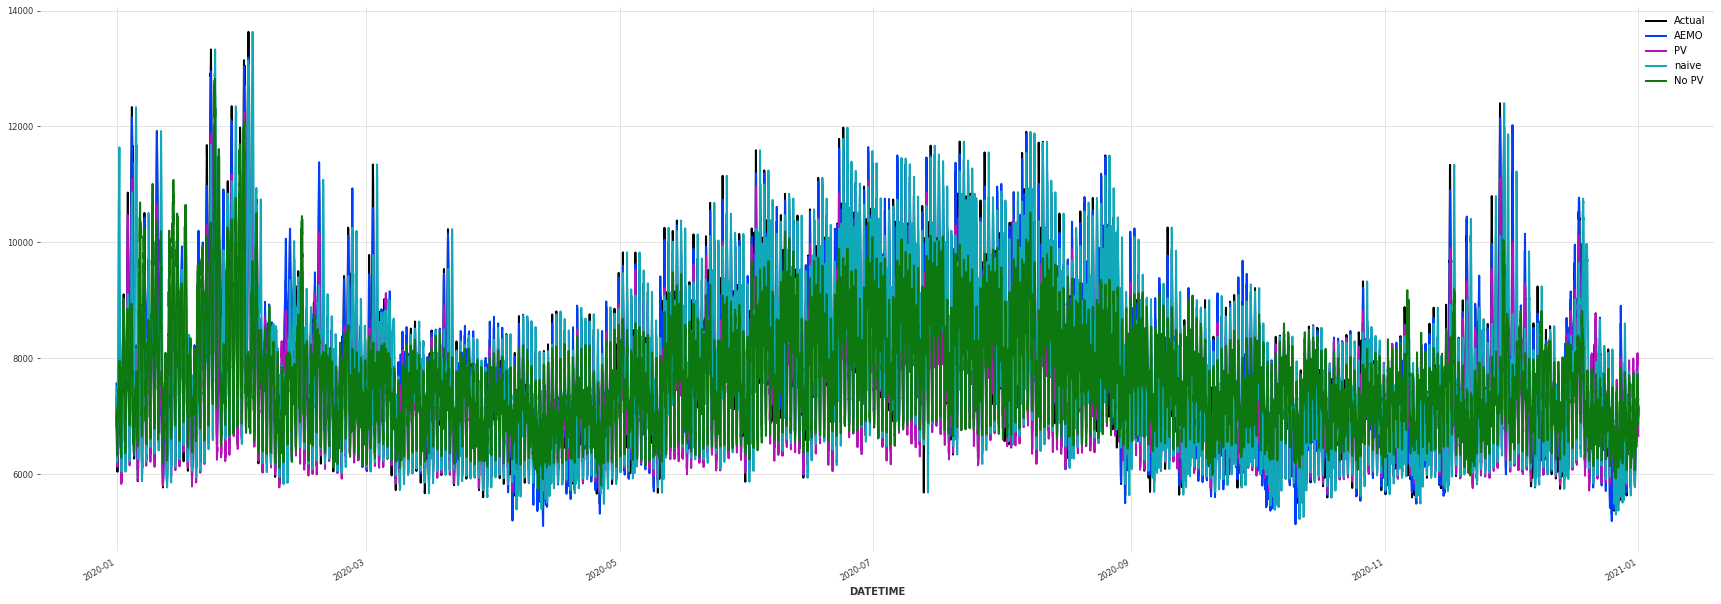

In [169]:
plt.figure(figsize=(30,10))
ref_series['TOTALDEMAND'].plot(label='Actual')
ref_series['FORECASTDEMAND'].plot(label='AEMO')
pv_series.plot(label='PV')
naive_forecasts.plot(label='naive')
no_pv_series.plot(label='No PV')

In [161]:
print("AEMO MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']), rmse(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']))
print("Naive MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], naive_forecasts), rmse(ref_series['TOTALDEMAND'], naive_forecasts))
print("PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],pv_series), rmse(ref_series['TOTALDEMAND'],pv_series))
print("Non-PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],no_pv_series), rmse(ref_series['TOTALDEMAND'],no_pv_series))



AEMO MAPE/RMSE: 2.044771615977553 230.12563788523752
Naive MAPE/RMSE: 5.890441292467695 694.4601090689131
PV prediction MAPE/RMSE 4.266520650108511 452.28112105845844
Non-PV prediction MAPE/RMSE 6.946295922915763 766.310301232191


Calculate the residuals between the predictions and the actuals


In [162]:
pv_diffs = ref_series['TOTALDEMAND'] - pv_series
non_pv_diffs = ref_series['TOTALDEMAND'] - no_pv_series

## Histogram of the distribution of errors for PV and non-PV roll-forward forecasts

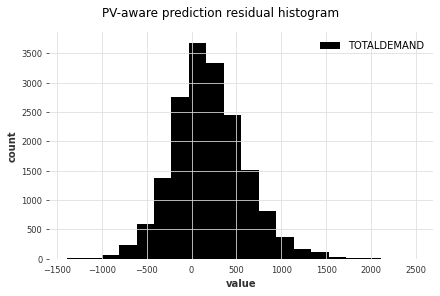

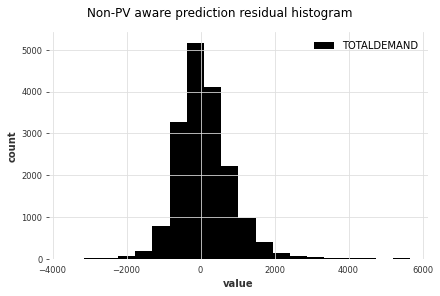

In [163]:
plot_hist(pv_diffs, bins=20, title="PV-aware prediction residual histogram")
plot_hist(non_pv_diffs, bins=20, title="Non-PV aware prediction residual histogram")

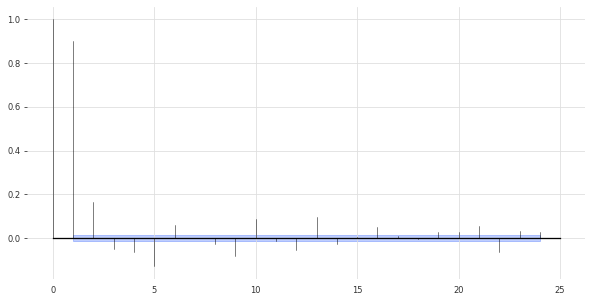

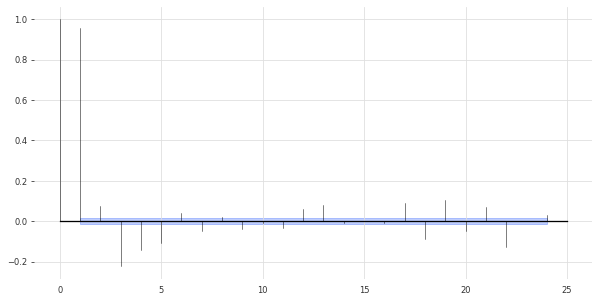

In [164]:
plot_pacf(pv_diffs, alpha=0.05)
plot_pacf(non_pv_diffs, alpha=0.05)

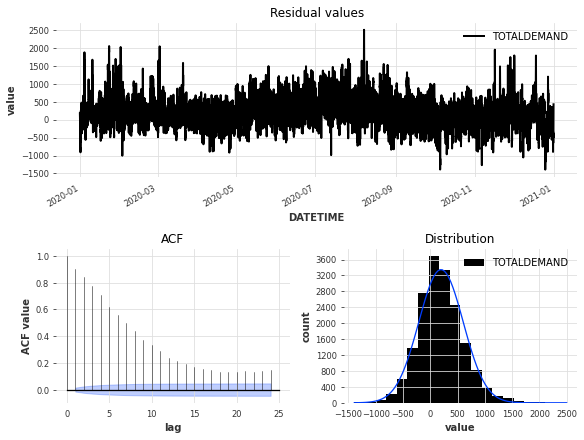

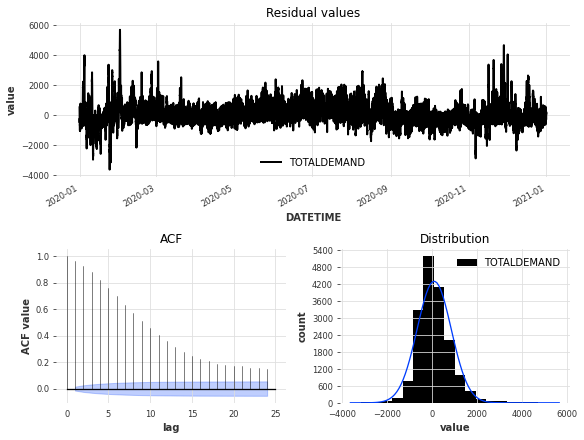

In [165]:
plot_residuals_analysis(pv_diffs)
plot_residuals_analysis(non_pv_diffs)

## Correlation of residuals with other predictors: PV data

In [166]:
def resid_correlation(residuals, main_data):
    cor_df = residuals.pd_dataframe()
    cor_df.rename(columns={'TOTALDEMAND':'RESIDUAL'}, inplace=True)
    return cor_df.merge(main_data, how='left', on='DATETIME')[['RESIDUAL','TOTALDEMAND','POWER','TEMPERATURE']].corr(method='pearson')

In [167]:
resid_correlation(pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,0.758418,-0.322447,-0.129267
TOTALDEMAND,0.758418,1.000000,-0.095293,0.041015
POWER,-0.322447,-0.095293,1.000000,0.500584
TEMPERATURE,-0.129267,0.041015,0.500584,1.000000


## Correlation of residuals with other predictors: non-PV data

In [168]:
resid_correlation(non_pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,0.750318,-0.209295,0.014112
TOTALDEMAND,0.750318,1.000000,-0.095293,0.041015
POWER,-0.209295,-0.095293,1.000000,0.500584
TEMPERATURE,0.014112,0.041015,0.500584,1.000000


Distribution of errors by time of day

In [202]:

daily_diffs.head()
#daily_diffs['DATETIME'] = pd.to_datetime(daily_diffs.index)
#daily_diffs.head()

component,RESIDUAL,TIMEOFDAY
DATETIME,,
2020-01-01 00:00:00,172.661625,00:00:00
2020-01-01 00:30:00,93.947055,00:30:00
2020-01-01 01:00:00,60.806044,01:00:00
2020-01-01 01:30:00,51.293120,01:30:00
2020-01-01 02:00:00,41.084598,02:00:00


In [237]:
def plot_residuals_by_hour(residuals):
    res = residuals.pd_dataframe()
    res.head()
    res.rename(columns={'TOTALDEMAND':'Residuals'},inplace=True)
    res['Time of day'] = res.index.time

    sns.set(rc={"figure.figsize": (25,5)})
    errorplot = sns.boxplot(data=res, x='Time of day',y='Residuals')
    errorplot.set_xticklabels(labels=res['Time of day'].unique(), rotation=45)
    ax1 = errorplot.axes
    ax1.axhline(0, ls='--', color='red')    

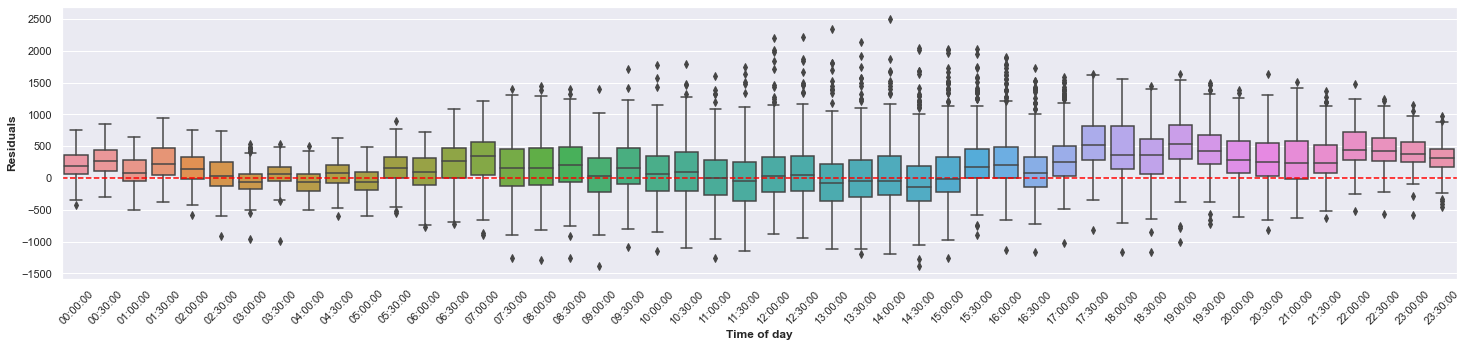

In [238]:


plot_residuals_by_hour(pv_diffs)

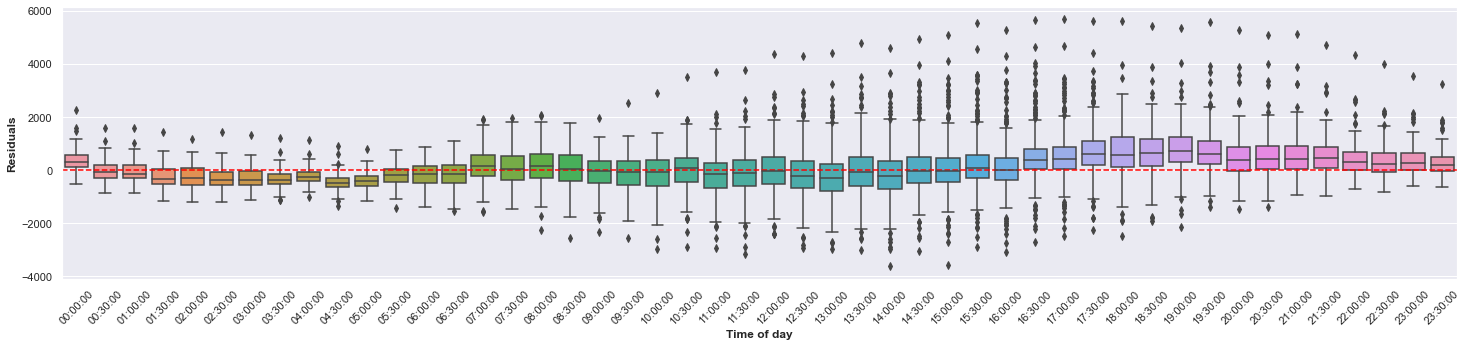

In [239]:
plot_residuals_by_hour(non_pv_diffs)